<!--
 * @Author: Wenyu Ouyang
 * @Date: 2022-11-10 10:13:24
 * @LastEditTime: 2022-11-10 10:16:12
 * @LastEditors: Wenyu Ouyang
 * @Description: Notebook for water balance analysis
 * @FilePath: 
 * Copyright (c) 2023-2024 Wenyu Ouyang. All rights reserved.
-->
# Impact on Water Balance

See the Water balance of all basins. A long-term water balance is a useful tool for understanding the hydrological cycle and the water balance of a basin. The water balance:
$$P=ET+Q$$
where $P$ is precipitation, $ET$ is evapotranspiration, and $Q$ is runoff.

The Budyko curve is a plot of the ratio of evapotranspiration to precipitation (ET/P) against the ratio of precipitation to potential evapotranspiration (P/PET). The Budyko curve is also a useful tool for understanding the hydrological cycle and the water balance of a basin. We can plot it to see what happened.

## Reading observation data for all basins

Import all the necessary packages.

In [1]:
import os
import sys

# Get the current directory of the notebook
notebook_dir = os.path.abspath('')
# Get the parent directory of the notebook directory
project_dir = os.path.dirname(notebook_dir)
# import the module using a relative path
sys.path.append(project_dir)
import definitions
from hydromtl.data.source.data_camels import Camels
from hydromtl.data.source_pro.data_camels_pro import CamelsPro
from scripts.mtl_results_utils import read_multi_single_exps_results

Please Check your directory:
ROOT_DIR of the repo:  /mnt/sdc/owen/code/HydroMTL
DATA_SOURCE_DIR of the repo:  /mnt/data/owen411/data
RESULT_DIR of the repo:  /mnt/sdc/owen/code/HydroMTL/results


/mnt/data/owen411/program/miniconda3/envs/MTL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import pandas as pd

Ids of all chosen basins in this paper.

In [3]:
camels591_file=os.path.join(definitions.RESULT_DIR, "camels_us_mtl_2001_2021_flow_screen.csv")
# if false, run camels_multioutput_preprocess.py in this directory
os.path.isfile(camels591_file)

True

In [4]:
camels591_ids = pd.read_csv(camels591_file,dtype={'GAGE_ID':str})['GAGE_ID'].values
camels591_ids[:5]

array(['01013500', '01022500', '01030500', '01031500', '01047000'],
      dtype=object)

In [5]:
# time_range = ["2001-10-01", "2021-10-01"]
time_range = ["2011-10-01", "2021-10-01"]

Reading precipitation data

In [6]:
source_path=[
            os.path.join(definitions.DATASET_DIR, "camelsflowet"),
            os.path.join(definitions.DATASET_DIR, "modiset4camels"),
            os.path.join(definitions.DATASET_DIR, "camels", "camels_us"),
            os.path.join(definitions.DATASET_DIR, "nldas4camels"),
            os.path.join(definitions.DATASET_DIR, "smap4camels"),
        ]
camels_pro = CamelsPro(source_path)

In [7]:
# precipitation from NLDAS 2
pet_prcps = camels_pro.read_relevant_cols(object_ids=camels591_ids, t_range_list=time_range,relevant_cols=["potential_evaporation", "total_precipitation"], forcing_type="nldas")

Read NLDAS forcing data for CAMELS-US: 100%|██████████| 591/591 [00:16<00:00, 35.58it/s]


The units of PET and PRCP are both $kg/m^2/day$. The density of water is 1000 $kg/m^3$ , so it is $mm/day$. 

In [8]:
pet = pet_prcps.mean(axis=1)[:, 0]
pet.shape

(591,)

In [9]:
p = pet_prcps.mean(axis=1)[:, 1]
p.shape

(591,)

Read streaflow and ET data

In [10]:
flow_ets = camels_pro.read_target_cols(object_ids=camels591_ids, t_range_list=time_range,target_cols=["usgsFlow", "ET"])

Read MODIS ET data for CAMELS-US: 100%|██████████| 591/591 [00:04<00:00, 129.58it/s]


The unit of streamflow is $ft^3/s$, convert it to mm/day.

The unit of ET is $0.1kg/m^2/8day$. When reading the data, its unit has been converted to $mm/day$.

In [11]:
basin_areas = camels_pro.read_basin_area(object_ids=camels591_ids)

In [12]:
flows = flow_ets[:, :, 0] / 35.314666721489
flows = flows / basin_areas * 1e3 / 1e6 * 86400
flows.shape

(591, 3653)

In [13]:
q = np.nanmean(flows, axis=1)
q.shape

(591,)

In [14]:
ets = flow_ets[:, :, 1]

In [15]:
et = np.nanmean(ets,axis=1)
et.shape

(591,)

## Reading predicted data for all basins

Read predicted streamflow and ET data of STL and MTL exps

In [16]:
mtl_exps = ["expmtl0011"]
stl_q_exps = ["expstlq0011"]
stl_et_exps = ["expstlet0011"]

In [17]:
exps_q_stl_mtl = stl_q_exps + mtl_exps
exps_et_stl_mtl = stl_et_exps + mtl_exps

Read predicted streamflow data of STL and MTL exps

In [18]:
exps_q_et_results, preds_q, obss_q = read_multi_single_exps_results(
    exps_q_stl_mtl, ensemble=-1, return_value=True
)


/mnt/sdc/owen/code/HydroMTL/hydromtl/utils/hydro_stat.py:414: RuntimeWarning: divide by zero encountered in double_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100
/mnt/sdc/owen/code/HydroMTL/hydromtl/utils/hydro_stat.py:414: RuntimeWarning: divide by zero encountered in double_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100


In [19]:
# Check if reading data is correct
from hydromtl.utils.hydro_stat import stat_error
inds_q_ = stat_error(obss_q[0], preds_q[-1])
np.median(inds_q_["NSE"]) == np.median(exps_q_et_results[-1])

/mnt/sdc/owen/code/HydroMTL/hydromtl/utils/hydro_stat.py:414: RuntimeWarning: divide by zero encountered in double_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100


True

In [20]:
q_mtl = preds_q[-1].mean(axis=1)
q_mtl.shape

(591,)

Read predicted ET data of STL and MTL exps

In [21]:
exps_et_q_results, preds_et, obss_et = read_multi_single_exps_results(
    exps_et_stl_mtl,
    var_idx=1,
    single_is_flow=False,
    flow_idx_in_mtl=0,
    ensemble=-1,
    return_value=True,
    et_unit="mm/day"
)

/mnt/sdc/owen/code/HydroMTL/hydromtl/utils/hydro_stat.py:414: RuntimeWarning: divide by zero encountered in double_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100


In [22]:
# Check if reading data is correct
inds_et_ = stat_error(obss_et[0], preds_et[-1], fill_nan="mean")
np.median(inds_et_["NSE"]) == np.median(exps_et_q_results[-1])

True

In [23]:
et_mtl = preds_et[-1].mean(axis=1)
et_mtl.shape

(591,)

Results of STL models

In [24]:
q_stl = preds_q[0].mean(axis=1)
et_stl = preds_et[0].mean(axis=1)

## Analysis for Water Balance

scatter plot of P-Q and ET with 1:1 line; P-ET and Q with 1:1 line

Calculate all these variables and plot them.

In [25]:
p_minus_q = p - q
runoff_coef = q / p
humidity_index = p / pet
evap_coef = et / p
aridity_index = pet / p

### P-Q ~ ET

Compare the P-Q of observation and ET of prediction.

1. Choose sites where water balance is nearly closed.

In [26]:
from hydromtl.visual.plot_stat import plot_scatter_with_11line

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='P-Q', ylabel='ET'>)

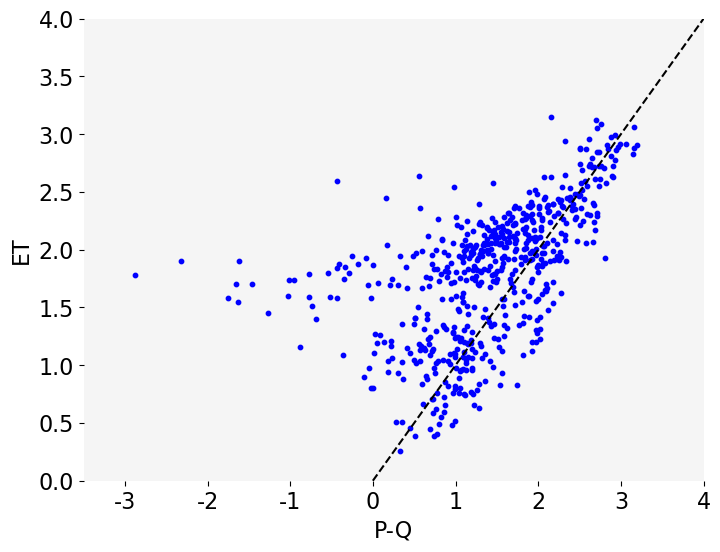

In [28]:
plot_scatter_with_11line(
    p_minus_q,
    et,
    xlabel="P-Q",
    ylabel="ET",
    xlim=[-3.5, 4],
    ylim=[0, 4],
    line_xlim=[0, 4],
    line_ylim=[0, 4],
    trans_ax_line=False,
)

size of points after filtering: 306


(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='P-Q', ylabel='ET'>)

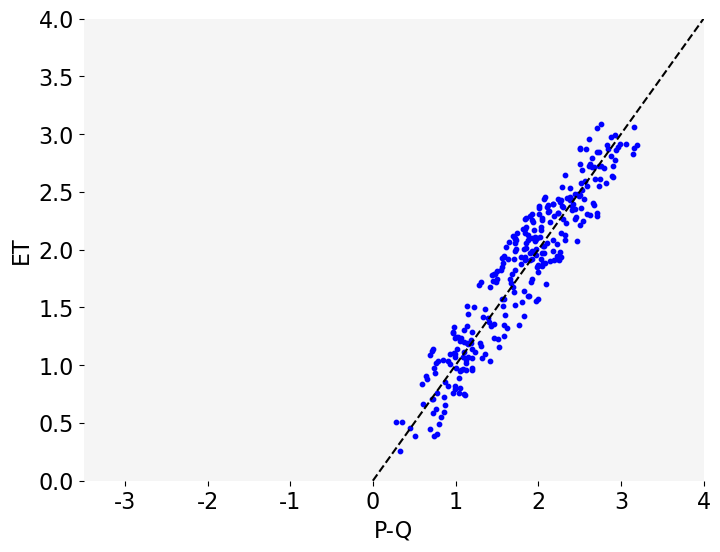

In [35]:
import math

def distance_from_line(x, y):
    # Equation of the line: y = x
    # Distance between a point (x, y) and the line y = x is given by:
    return abs(y - x) / math.sqrt(2)

def filter_points(points, threshold):
    filtered_points = []
    for point in points:
        x, y = point
        distance = distance_from_line(x, y)
        if distance < threshold:
            filtered_points.append(point)
    return filtered_points

# Example usage:
points = list(zip(p_minus_q, et))
threshold = 0.3

filtered_points = filter_points(points, threshold)
print("size of points after filtering:", len(filtered_points))
filtered_indices = [index for index, point in enumerate(points) if point in filtered_points]
x_coords, y_coords = zip(*filtered_points)
plot_scatter_with_11line(
    x_coords,
    y_coords,
    xlabel="P-Q",
    ylabel="ET",
    xlim=[-3.5, 4],
    ylim=[0, 4],
    line_xlim=[0, 4],
    line_ylim=[0, 4],
    trans_ax_line=False,
)

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='P-Q', ylabel='ET'>)

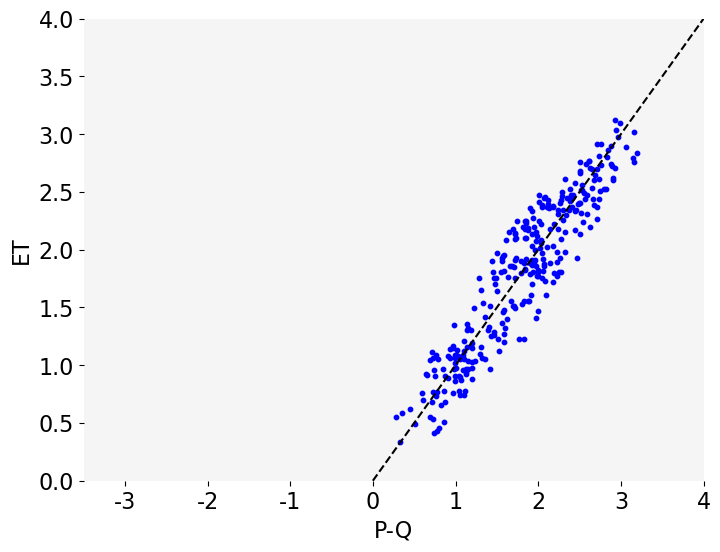

In [39]:
plot_scatter_with_11line(
    p_minus_q[filtered_indices],
    et_stl[filtered_indices],
    xlabel="P-Q",
    ylabel="ET",
    xlim=[-3.5, 4],
    ylim=[0, 4],
    line_xlim=[0, 4],
    line_ylim=[0, 4],
    trans_ax_line=False,
)

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='P-Q', ylabel='ET'>)

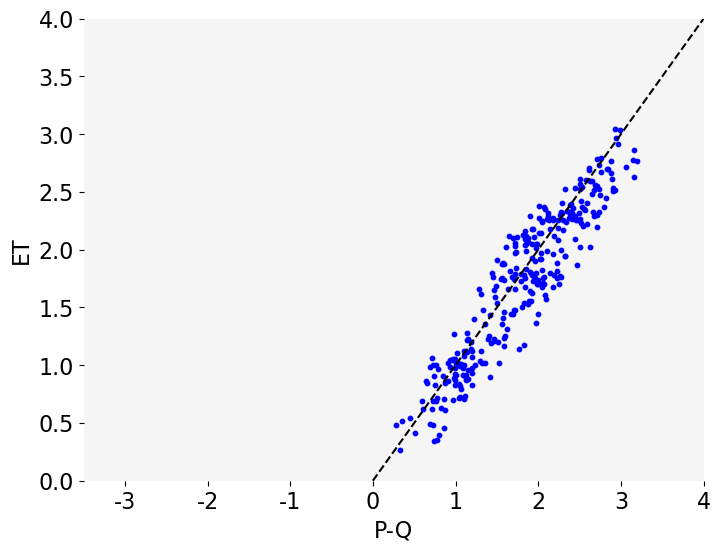

In [40]:
plot_scatter_with_11line(
    p_minus_q[filtered_indices],
    et_mtl[filtered_indices],
    xlabel="P-Q",
    ylabel="ET",
    xlim=[-3.5, 4],
    ylim=[0, 4],
    line_xlim=[0, 4],
    line_ylim=[0, 4],
    trans_ax_line=False,
)

### P-ET ~ Q

Compare the P-ET of observation and Q of prediction.

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='P-ET', ylabel='Q'>)

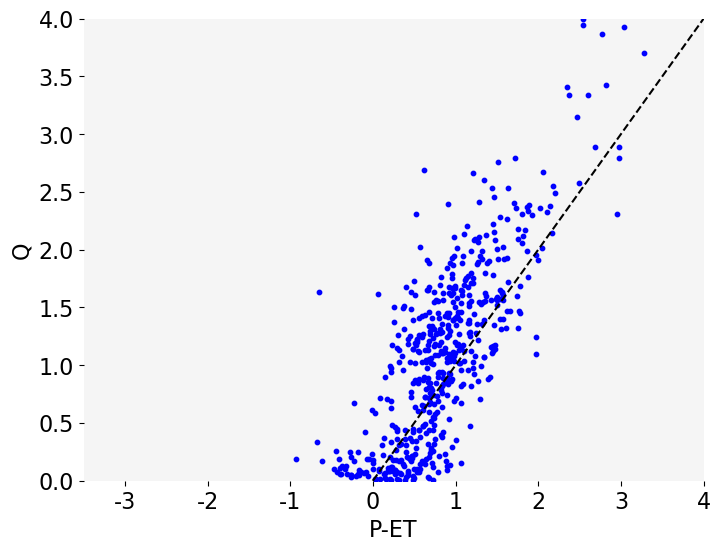

In [45]:
plot_scatter_with_11line(
    p-et,
    q,
    xlabel="P-ET",
    ylabel="Q",
    xlim=[-3.5, 4],
    ylim=[0, 4],
    line_xlim=[0, 4],
    line_ylim=[0, 4],
    trans_ax_line=False,
)

size of points after filtering: 306


(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='P-ET', ylabel='Q'>)

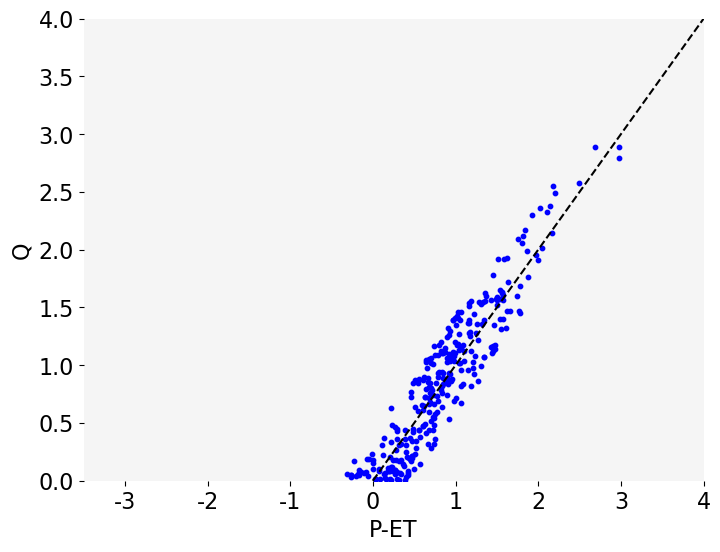

In [48]:
points_ = list(zip(p-et, q))
threshold = 0.3

filtered_points_ = filter_points(points_, threshold)
print("size of points after filtering:", len(filtered_points_))
filtered_indices_ = [index for index, point in enumerate(points_) if point in filtered_points_]
x_coords_, y_coords_ = zip(*filtered_points_)
plot_scatter_with_11line(
    x_coords_,
    y_coords_,
    xlabel="P-ET",
    ylabel="Q",
    xlim=[-3.5, 4],
    ylim=[0, 4],
    line_xlim=[0, 4],
    line_ylim=[0, 4],
    trans_ax_line=False,
)

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='P-ET', ylabel='Q'>)

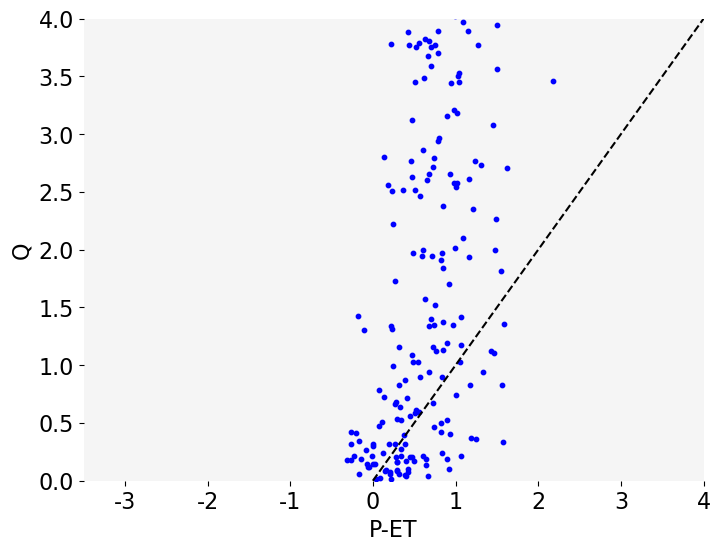

In [50]:
plot_scatter_with_11line(
    (p-et)[filtered_indices_],
    q_stl[filtered_indices_],
    xlabel="P-ET",
    ylabel="Q",
    xlim=[-3.5, 4],
    ylim=[0, 4],
    line_xlim=[0, 4],
    line_ylim=[0, 4],
    trans_ax_line=False,
)

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='P-ET', ylabel='Q'>)

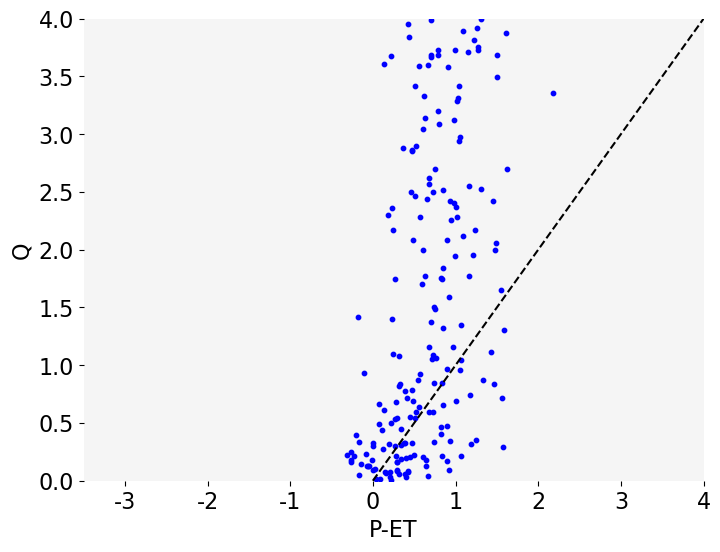

In [51]:
plot_scatter_with_11line(
    (p-et)[filtered_indices_],
    q_mtl[filtered_indices_],
    xlabel="P-ET",
    ylabel="Q",
    xlim=[-3.5, 4],
    ylim=[0, 4],
    line_xlim=[0, 4],
    line_ylim=[0, 4],
    trans_ax_line=False,
)

No significant difference for water balance between STL and MTL as their prediction performance are similar.